In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from sklearn.cluster import KMeans 
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from pathlib import Path

In [3]:
import sys

sys.path.append('../../../src')



In [4]:
from base_exp_gen import generate_experiment as GEN_EXP
from clustering_algos import agglomerative_clustering, kmeans_clustering, box_clustering, optimal_clustering
from sklearn.model_selection import train_test_split as datasplit
from sklearn.ensemble import GradientBoostingRegressor as GDBR
from evaluations import computeATT_per_cluster as ATTC, predict_cf, calculate_ite, get_homogeneity, generate_paths



In [5]:
np.random.seed(seed = 0)

In [6]:
fonts = {'family': 'cmr10','weight': 'normal',
            'size': 20}    
div = 1

l1 = 22/div
l2 = 20/div
l3 = 13/(div-0.2)

mpl.rcParams['xtick.labelsize'] = l2
mpl.rcParams['ytick.labelsize'] = l2
mpl.rcParams['axes.labelsize'] = l1
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = l3

#axes_font = {'labelsize':l1}
#mpl.rc('font', **font)
#xticks = {'labelsize':l2}# 'ytick.labelsize':20}
#yticks = {'labelsize':l2}# 'ytick.labelsize':20}
#legend = {'fontsize':l3}
# tex = {'usetex':True}
#mpl.rc('axes', **axes_font)
#mpl.rc('xtick', **xticks)
#mpl.rc('ytick', **yticks)
#mpl.rc('font', **fonts)
#mpl.rc('legend', **legend)

In [7]:
r1 =np.sqrt(1/3/np.pi)
r2 = np.sqrt((1/3/np.pi+r1**2))
r1, r2

(0.32573500793527993, 0.46065886596178063)

In [8]:
print(mpl.rcParams['xtick.labelsize'])

20.0


In [9]:
pd.set_option("display.max_columns", None)


### Generate Experiment

In [10]:
%%time
path_figs = './figs/2Mstd5/'
save = True
Path(path_figs).mkdir(exist_ok = True, parents = True)

CPU times: user 179 µs, sys: 118 µs, total: 297 µs
Wall time: 600 µs


In [11]:
N,D = 2*10**6, 2
x = int((N)**(1/4))
clusters = x**2
print("Number of Clusters:{}, Number of Points:{}".format(clusters, N))
kw_generate =  {'N':N, 'D':D,'f_gen_name': 'uniform_gen','low':0, 'high': 1}
centers = [[0.5,0.5],[0.5,0.5]]
r_small = [0, 0.325735]
r_big = [0.325735,0.46065886]
eligibilities = [2,1]
kw_cluster =  {'f_class_name':'circle_class4', 'centers': centers,
               'eligibilities':eligibilities,'r_small': r_small, 'r_big':r_big}
kw_treatment = {'f_treat_name' :'uniform_treat','choices':[0,1], 'probabilities':[0.5,0.5]}

std = 2
stats = np.array([[1, std], [0, std], [0, std], [1, std],[1, std],
                  [2, std]])
kw_outcome = {'f_outcome_name': 'outcome1','treatment':'Treatment', 'cls':'C', 'stats':stats}

data = GEN_EXP(kw_generate, kw_cluster, kw_treatment, kw_outcome).dat
data = calculate_ite(data.copy(), treatment = 'Treatment',
                     counterfactual = 'Ycf', outcome = 'Y', ite_name = 'ITE')

Number of Clusters:1369, Number of Points:2000000


In [12]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE
0,0.548814,0.715189,2,0,2.663514,-1.553727,-4.217241
1,0.602763,0.544883,2,0,0.322200,2.393922,2.071722
2,0.423655,0.645894,2,0,5.106052,2.580146,-2.525906
3,0.437587,0.891773,1,1,-2.702391,-0.191128,-2.511263
4,0.963663,0.383442,0,0,4.275959,1.875316,-2.400644


In [13]:
data.describe()

,x0,x1,C,Treatment,Y,Ycf,ITE
count,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06,2.000000e+06
mean,4.997836e-01,5.001988e-01,1.000020e+00,5.001005e-01,8.336311e-01,8.356772e-01,1.001270e+00
std,2.887267e-01,2.886267e-01,8.164207e-01,5.000001e-01,2.114240e+00,2.114881e+00,2.942197e+00
min,1.637144e-07,2.516784e-08,0.000000e+00,0.000000e+00,-9.038117e+00,-9.171530e+00,-1.255560e+01
25%,2.495544e-01,2.502948e-01,0.000000e+00,0.000000e+00,-5.943142e-01,-5.947750e-01,-9.836229e-01
50%,4.999703e-01,5.003810e-01,1.000000e+00,1.000000e+00,8.322795e-01,8.316667e-01,9.981741e-01
75%,7.499998e-01,7.500191e-01,2.000000e+00,1.000000e+00,2.258773e+00,2.263374e+00,2.988030e+00
max,9.999993e-01,9.999997e-01,2.000000e+00,1.000000e+00,1.164953e+01,1.161717e+01,1.488689e+01


In [14]:
data['C'].value_counts()/len(data)

1    0.333458
2    0.333281
0    0.333261
Name: C, dtype: float64

In [15]:
data.groupby('C').ITE.mean()

C
0    0.001922
1    1.000156
2    2.001676
Name: ITE, dtype: float64

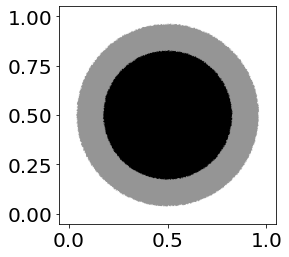

In [16]:
fig, ax = plt.subplots()

ax.scatter(data['x0'].values, data['x1'].values, c=data['C'].values, cmap = 'Greys', s=0.1)

if save:
    ax.set_aspect('equal', adjustable='box')
    fig.savefig(path_figs+'data.jpeg',bbox_inches='tight', pad_inches = 0)

plt.show()

In [17]:
from econml.metalearners import XLearner as XL
from sklearn.ensemble import RandomForestClassifier as RF

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


 ### Estimate ITE with Gradient Boosting Trees

In [18]:
%%time
f1_kwargs = {'n_estimators':400, 'max_depth':18}
f2_kwargs = {'n_estimators':400, 'max_depth':18}

data, models = predict_cf(data.copy(), col_select = ['x0', 'x1'], f1 = GDBR,
                          f2 = GDBR, cf_name = 'Ycf-GDBR', f1_kwargs=f1_kwargs, 
                          f2_kwargs=f2_kwargs, ite_name ='ITE-GDBR')

CPU times: user 1h 24min 18s, sys: 5.96 s, total: 1h 24min 24s
Wall time: 1h 24min 39s


In [19]:
data.head(5)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR
0,0.548814,0.715189,2,0,2.663514,-1.553727,-4.217241,1,2.086240,-0.577274
1,0.602763,0.544883,2,0,0.322200,2.393922,2.071722,0,1.809118,1.486919
2,0.423655,0.645894,2,0,5.106052,2.580146,-2.525906,1,2.010866,-3.095186
3,0.437587,0.891773,1,1,-2.702391,-0.191128,-2.511263,0,-0.156119,-2.546272
4,0.963663,0.383442,0,0,4.275959,1.875316,-2.400644,0,2.615879,-1.660080


### Model performance

In [20]:
filt = (data['Treatment'] == 1) & (data['C'] == 1) & (data['IS_TEST'] ==0)
data.groupby(['Treatment', 'C', 'IS_TEST'])[['Y', 'Ycf', 'Ycf-GDBR','ITE', 'ITE-GDBR']].mean()

Y       Ycf  Ycf-GDBR       ITE  ITE-GDBR
Treatment C IS_TEST                                                  
0         0 0        0.992536  1.003570  0.997750  0.011034  0.005213
            1        1.017754  1.014574  0.995072 -0.003180 -0.022682
          1 0        0.001932  1.003415  1.014920  1.001484  1.012988
            1        0.002556  1.002949  1.015370  1.000393  1.012814
          2 0       -0.003130  2.000247  1.989099  2.003377  1.992229
            1       -0.000504  2.010796  1.989470  2.011300  1.989974
1         0 0        0.995674  0.998884  0.974441 -0.003210  0.021233
            1        1.004356  1.013408  0.975560 -0.009052  0.028796
          1 0        1.001525  0.001405  0.022303  1.000120  0.979222
            1        0.997777  0.003043  0.020845  0.994734  0.976932
          2 0        2.004153  0.000746 -0.003521  2.003407  2.007674
            1        1.995350  0.016904 -0.004203  1.978447  1.999554

### Apply clustering Box and Kmeans

In [21]:
%%time
col_select = ['x0', 'x1']
data,_ = box_clustering(data.copy(), clusters = clusters, col_select = col_select )
data,_ = kmeans_clustering(data.copy(), clusters = clusters, col_select = col_select )


CPU times: user 21h 5min 15s, sys: 1h 18min 9s, total: 22h 23min 25s
Wall time: 2h 1min 16s


In [22]:
data.head()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,2.663514,-1.553727,-4.217241,1,2.086240,-0.577274,982,675
1,0.602763,0.544883,2,0,0.322200,2.393922,2.071722,0,1.809118,1.486919,762,203
2,0.423655,0.645894,2,0,5.106052,2.580146,-2.525906,1,2.010866,-3.095186,866,271
3,0.437587,0.891773,1,1,-2.702391,-0.191128,-2.511263,0,-0.156119,-2.546272,1200,1166
4,0.963663,0.383442,0,0,4.275959,1.875316,-2.400644,0,2.615879,-1.660080,553,459


### Calculte ATT PER Cluster  known CF

$
\begin{align}
E[Y^1|T=1,Ci ]-E[Y^0|T=1, Ci]
\end{align}
$

In [23]:
ite_name = 'ITE'
box = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', 
           ITE_name = ite_name, hom_name = 'Box-Hom',
          att = False)

kmeans = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
              hom_name = 'Kmeans-Hom', att = False)


In [24]:
box.head(3)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
0,0,0.053752,1409.0,1.0,0.000705
1,1,0.025122,1451.0,1.0,0.000726
2,2,-0.040744,1399.0,1.0,0.000700


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


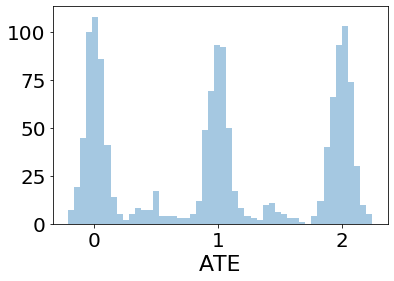

In [25]:
path2 = path_figs+'histograms/'
Path(path2).mkdir(exist_ok = True)

kde = False
bins = 50
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box['Box-ATT'].values , bins=bins, kde = False,ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'boxhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


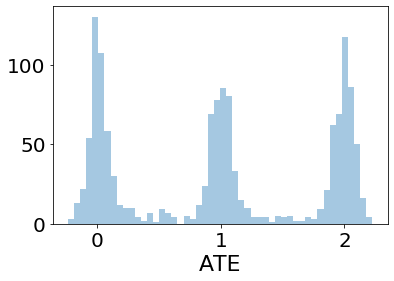

In [26]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans['Kmeans-ATT'],
                  bins = bins, kde = kde, ax = ax)

ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
if save:
    fig.savefig(path2+'Kmhist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


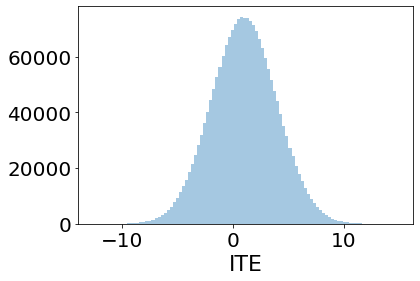

In [27]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE'], bins = 100,
                  kde = kde, ax = ax)
ax.set_xlabel('ITE')
#ax.set_ylabel('weight')

if save:
    fig.savefig(path2+'itehist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()


In [28]:
box.describe()

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights
count,1369.00000,1369.000000,1369.000000,1369.000000,1369.000000
mean,684.00000,1.001329,1460.920380,0.961037,0.000730
std,395.34057,0.804953,37.097551,0.116090,0.000019
min,0.00000,-0.206394,1345.000000,0.500666,0.000673
25%,342.00000,0.072095,1435.000000,1.000000,0.000718
50%,684.00000,1.004046,1460.000000,1.000000,0.000730
75%,1026.00000,1.925001,1486.000000,1.000000,0.000743
max,1368.00000,2.241838,1590.000000,1.000000,0.000795


### Calculate ATT per Cluster not known Model Calculated CF

In [29]:
ite_name = 'ITE-GDBR'
box2 = ATTC(data.copy(), cluster_name = 'Box-Cluster', ATT_CLUST_name='Box-ATT',
           points_name='Box-points', weight_names='Box-Weights', ITE_name = ite_name,
            hom_name = 'Box-Hom', att = False)

kmeans2 = ATTC(data.copy(), cluster_name = 'Kmeans-Cluster', ATT_CLUST_name='Kmeans-ATT',
           points_name='Kmeans-points', weight_names='Kmeans-Weights',ITE_name = ite_name,
               hom_name = 'Kmeans-Hom', att = False)



/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


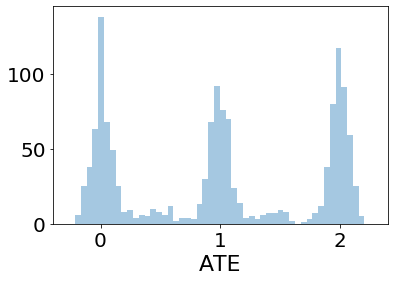

In [30]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(box2['Box-ATT'],bins = bins, kde = kde,ax = ax )
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
ax.set_xlim(-0.4,2.4)

if save:
    fig.savefig(path2+'Box2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()




/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


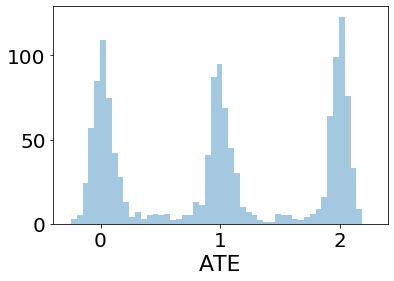

In [31]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(kmeans2['Kmeans-ATT'], 
             bins = bins, kde = kde, ax = ax)
ax.set_xlabel('ATE')
#ax.set_ylabel('weight')
ax.set_xlim(-0.4,2.4)

if save:

    fig.savefig(path2+'KM2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

/home/mavrog2/.conda/envs/jorje/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


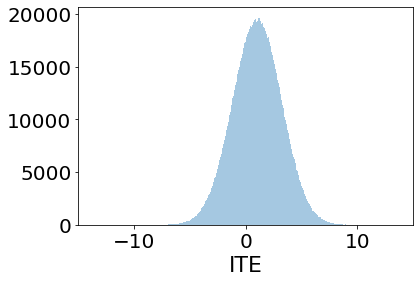

In [32]:
fig, ax = plt.subplots(1,1)
ax = sns.distplot(data['ITE-GDBR'],bins = 400, kde = kde, ax = ax)

ax.set_xlabel('ITE')
#ax.set_ylabel('weight')
ax.set_xlim(-15,15)
if save:

    fig.savefig(path2+'ITE2hist.pdf', bbox_inches='tight',pad_inches = 0)

plt.show()

### Optimal 3-Clustering
#### Cluster the ATTs for the 4 methods 
1. Box with sampled Ites
2. Kmeans with sampled Ites
3. Box with estimated Ites
4. Kmeans with estimated Ites

In [33]:
%%time
#all_data = [box, kmeans, agglo, box2, kmeans2, agglo2]
all_data = [box, kmeans, box2, kmeans2]

#names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']
#names2 = ['Box-ATT', 'Kmeans-ATT', 'Agglo-ATT', 'Box-ATT', 'Kmeans-ATT', 'Agglo-ATT']

names_to_give = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']
names_to_find= ['Box-ATT', 'Kmeans-ATT',  'Box-ATT', 'Kmeans-ATT']

weights = ['Box-Weights', 'Kmeans-Weights', 'Box-Weights', 'Kmeans-Weights']

clusts = 3
for i, (dd, name, name2,w) in enumerate(zip(all_data, names_to_give, names_to_find,weights)):
    all_data[i], _ = optimal_clustering(dd, max_clusters = clusts, col_select = name2, 
                      cluster_name = name, N=N )
    


CPU times: user 1.19 s, sys: 38.4 ms, total: 1.23 s
Wall time: 1.43 s


In [34]:
box['Box-Cl2'].value_counts()

0    471
2    451
1    447
Name: Box-Cl2, dtype: int64

In [35]:
box.head(2)

,Box-Cluster,Box-ATT,Box-points,Box-Hom,Box-Weights,Box-Cl2
0,0,0.053752,1409.0,1.0,0.000705,0
1,1,0.025122,1451.0,1.0,0.000726,0


In [36]:
data2 = data.copy()
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster
0,0.548814,0.715189,2,0,2.663514,-1.553727,-4.217241,1,2.086240,-0.577274,982,675
1,0.602763,0.544883,2,0,0.322200,2.393922,2.071722,0,1.809118,1.486919,762,203


### 3 Clustering in the ITEs

In [37]:
cluster_name1 = 'ITE-2CTrue'
col1 = 'ITE'
filt11 = data2[col1] <= 0.5
filt21 = data2[col1] >= 0.5
filt31 = data2[col1] >= 1.5

data2[cluster_name1] = 0
data2.loc[filt11,cluster_name1] = 0
data2.loc[filt21, cluster_name1] = 1
data2.loc[filt31, cluster_name1] = 2

cluster_name2 = 'ITE-2CGDBR'
col2 = 'ITE-GDBR'
filt12 = data2[col2] <= 0.5
filt22 = data2[col2] >= 0.5
filt32 = data2[col2] >= 1.5

data2[cluster_name2] = 0
data2.loc[filt12,cluster_name2] = 0
data2.loc[filt22, cluster_name2] = 1
data2.loc[filt32, cluster_name2] = 2

#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CTrue',col_select = ['ITE'] )
#data2,_ = kmeans_clustering(data2,clusters = clusts, cluster_name = 'ITE-2CGDBR',col_select = ['ITE-GDBR'] )

### Merge 3 Clustering with initial data

In [38]:
#merge_names = ['Box-Cluster', 'Kmeans-Cluster', 'Agglomerative-Cluster']*2
#class_names = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2', 'Kmeans2-Cl2', 'Agglo2-Cl2']

merge_names = ['Box-Cluster', 'Kmeans-Cluster']*2
class_names = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2']

for dd, merge_name, class_name in zip(all_data, merge_names, class_names):
    dd2 = dd[[merge_name, class_name]]


    data2 = data2.merge(dd2, on = merge_name, how = 'left' )

In [39]:
data2.head(2)

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,ITE-2CGDBR,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2
0,0.548814,0.715189,2,0,2.663514,-1.553727,-4.217241,1,2.086240,-0.577274,982,675,0,0,2,2,2,2
1,0.602763,0.544883,2,0,0.322200,2.393922,2.071722,0,1.809118,1.486919,762,203,2,1,2,2,2,2


### Plot reconstruction of data

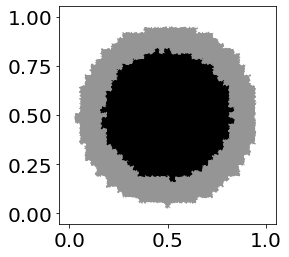

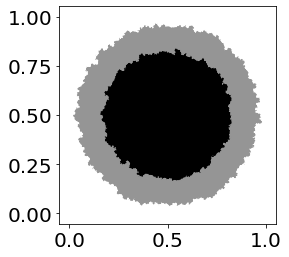

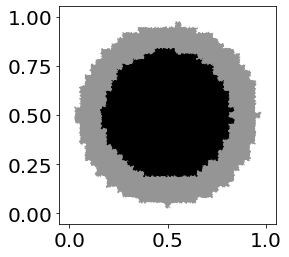

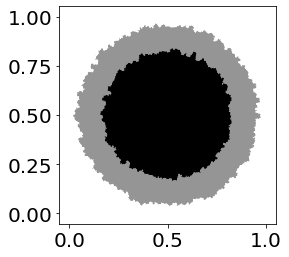

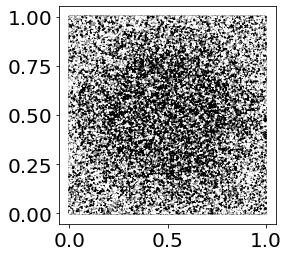

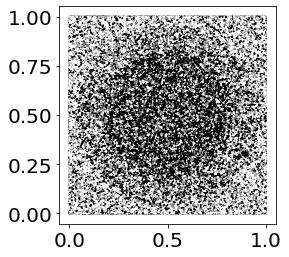

CPU times: user 11min 41s, sys: 13.5 s, total: 11min 54s
Wall time: 11min 41s


In [40]:
%%time
#class_names1 = ['Box-Cl2', 'Kmeans-Cl2', 'Agglo-Cl2', 'Box2-Cl2',
                #'Kmeans2-Cl2', 'Agglo2-Cl2', 'ITE-CTrue', 'ITE-CGDBR']

class_names2 = ['Box-Cl2', 'Kmeans-Cl2',  'Box2-Cl2', 'Kmeans2-Cl2','ITE-2CTrue', 'ITE-2CGDBR']


#patth to save
path3 = path_figs+'reconstruction/'
Path(path3).mkdir(exist_ok = True, parents = True)
use_poly = False
for name in class_names2:
    #data2.plot.scatter(x='x0', y='x1', c=name, colormap='inferno')
    fig, ax = plt.subplots()
    if not use_poly:
        sc = ax.scatter(data2['x0'].values, data2['x1'].values, c=data2[name].values, cmap = 'Greys', s = 1)
    else:
        polygons, colors = generate_paths(K, Cdraw = avg_c, Cdraw_name=name)
        coll = mpl.collections.PolyCollection(polygons)
        coll.set(array = np.array(colors), cmap = 'Greys')
        ax.add_collection(coll)
        ax.figure.colorbar(coll)
    #ax.set_title(name)
    #fig.colorbar(sc)
    if save:
        ax.set_aspect('equal', adjustable='box')
        fig.savefig(path3+'{}.jpeg'.format(name), bbox_inches='tight',pad_inches = 0)

    plt.show()
    

In [41]:
def MAE_pd(group, name1,name2,column_name):
    
    group[column_name] = np.abs(group[name1].values-group[name2].mean())
    return group
    
    

In [42]:
ite_column = 'ITE-GDBR'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-GDBR'))

In [43]:
ite_column = 'ITE'

for clust2 in class_names2:
    data2 = data2.groupby(clust2).apply(lambda x: MAE_pd(x, 'C', ite_column, clust2+'-err-True-ITE'))

In [44]:
errors = data2.describe().loc[['mean', 'std'], [col for col in data2.columns if 'err' in col]].T

In [45]:
errors.sort_values(by = 'mean')

,mean,std
Kmeans-Cl2-err-True-ITE,0.051746,0.177076
Kmeans-Cl2-err-GDBR,0.054277,0.176343
Kmeans2-Cl2-err-GDBR,0.054616,0.176864
Kmeans2-Cl2-err-True-ITE,0.055052,0.176703
Box2-Cl2-err-GDBR,0.060131,0.189726
Box2-Cl2-err-True-ITE,0.061294,0.189337
Box-Cl2-err-GDBR,0.066413,0.188476
Box-Cl2-err-True-ITE,0.066441,0.188457
ITE-2CTrue-err-GDBR,1.154431,0.780993
ITE-2CGDBR-err-True-ITE,1.532777,0.832463


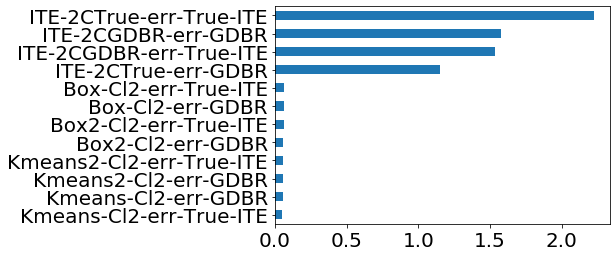

In [46]:
ax = errors['mean'].sort_values().plot.barh()
plt.show()

In [47]:
from evaluations import confusion_matrix
    

In [48]:
from IPython.display import display

path4 = path_figs+'matrices/'
Path(path4).mkdir(exist_ok = True)
for name in class_names2:
    mat = confusion_matrix(data2, 'C', name, 3, save = True, save_dir = path4)
    print(name)
    display(mat)

Box-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.980755,0.019245,0.00000
C1 True,0.051645,0.928235,0.02012
C2 True,0.000000,0.031910,0.96809


Kmeans-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.970919,0.029081,0.000000
C1 True,0.031289,0.947659,0.021052
C2 True,0.000000,0.022130,0.977870


Box2-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.972873,0.027127,0.000000
C1 True,0.041983,0.934563,0.023454
C2 True,0.000000,0.028522,0.971478


Kmeans2-Cl2


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.979633,0.020367,0.000000
C1 True,0.040731,0.937010,0.022259
C2 True,0.000000,0.021509,0.978491


ITE-2CTrue


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.569925,0.131868,0.298207
C1 True,0.430127,0.140571,0.429302
C2 True,0.297624,0.132142,0.570234


ITE-2CGDBR


,C0 Pred,C1 Pred,C2 Pred
C0 True,0.594961,0.171665,0.233374
C1 True,0.403531,0.194544,0.401925
C2 True,0.227674,0.173996,0.598330


In [49]:
data2.groupby('ITE-2CGDBR').std()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.317775,0.317848,0.762295,0.5,1.858775,2.076862,2.351351,0.400496,0.654914,1.232697,435.027635,395.667223,0.719798,0.764683,0.763838,0.764494,0.766210,0.184924,0.178913,0.189233,0.176781,0.773051,0.762295,0.185160,0.179994,0.189130,0.176875,0.950688,0.762295
1,0.288269,0.287771,0.799828,0.5,0.778138,2.113960,2.045109,0.399265,0.750284,0.287677,393.998503,394.392134,0.898309,0.805122,0.800882,0.802976,0.805079,0.190070,0.176897,0.191064,0.178453,0.810214,0.480045,0.190044,0.177646,0.190655,0.178280,1.093801,0.475109
2,0.256842,0.256723,0.765881,0.5,2.677864,2.152386,2.354243,0.399828,0.869264,1.221800,351.594598,394.361964,0.720711,0.775982,0.769093,0.772120,0.773991,0.191156,0.173417,0.189554,0.176155,0.770693,0.765881,0.190926,0.173820,0.188918,0.175778,0.947556,0.765881


In [50]:
data2.groupby('ITE-2CGDBR').mean()

,x0,x1,C,Treatment,Y,Ycf,ITE,IS_TEST,Ycf-GDBR,ITE-GDBR,Box-Cluster,Kmeans-Cluster,ITE-2CTrue,Box-Cl2,Kmeans-Cl2,Box2-Cl2,Kmeans2-Cl2,Box-Cl2-err-GDBR,Kmeans-Cl2-err-GDBR,Box2-Cl2-err-GDBR,Kmeans2-Cl2-err-GDBR,ITE-2CTrue-err-GDBR,ITE-2CGDBR-err-GDBR,Box-Cl2-err-True-ITE,Kmeans-Cl2-err-True-ITE,Box2-Cl2-err-True-ITE,Kmeans2-Cl2-err-True-ITE,ITE-2CTrue-err-True-ITE,ITE-2CGDBR-err-True-ITE
ITE-2CGDBR,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.499530,0.500233,0.700532,0.499291,0.834311,0.839372,-1.027983,0.200662,0.834403,-1.079334,684.301338,680.704041,0.399900,0.691694,0.705611,0.700235,0.698452,0.070739,0.058268,0.063972,0.058701,1.129825,1.779865,0.069965,0.054843,0.064285,0.058296,2.212758,1.728514
1,0.499870,0.500975,1.004332,0.500736,0.817292,0.824175,0.989425,0.199021,0.816728,0.999935,685.356160,681.526248,0.995552,0.988804,1.002591,0.997109,0.997198,0.066420,0.053973,0.059803,0.054372,1.275916,0.639766,0.066599,0.051394,0.061077,0.054891,2.270915,0.643598
2,0.499998,0.499825,1.295803,0.500627,0.840110,0.837042,3.023404,0.199771,0.835323,3.071611,683.751921,682.438375,1.598475,1.275555,1.288848,1.283102,1.285088,0.062110,0.050444,0.056458,0.050662,1.125690,1.775809,0.062869,0.048823,0.058416,0.051897,2.207870,1.727601


In [51]:
np.mean(np.abs(data2['C'] - data2['ITE-GDBR'])), np.std(np.abs(data2['C'] - data2['ITE-GDBR']))

(1.6189948103275102, 1.2256379212814783)